In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [6]:

np.random.seed(42)
n = 5000
data = pd.DataFrame({
    'ClientID': range(1, n + 1),
    'GPA': np.round(np.random.normal(3.2, 0.4, n), 2),  
    'FamilyIncome_k': np.round(np.random.normal(55, 20, n), 1),  
    'IELTS': np.round(np.clip(np.random.normal(6.5, 1, n), 4.5, 9), 1),  
    'ProgramInterest': np.random.choice(['STEM', 'Business', 'Arts', 'Technical'], size=n, p=[0.4, 0.3, 0.2, 0.1]),
    'ScholarshipPreference': np.random.choice(['High', 'Medium', 'Low'], size=n, p=[0.2, 0.5, 0.3]),
    'CostSensitivity': np.random.choice(['High', 'Medium', 'Low'], size=n, p=[0.4, 0.4, 0.2])
})

In [7]:
def classify_destination(row):
    if row['GPA'] > 3.5 and row['FamilyIncome_k'] > 70:
        return np.random.choice(['USA', 'UK'])  
    elif row['IELTS'] >= 6.5 and 40 <= row['FamilyIncome_k'] <= 70:
        return np.random.choice(['Canada', 'Australia'])  
    elif row['ProgramInterest'] == 'Technical':
        return np.random.choice(['Singapore', 'Japan', 'South Korea'])  
    elif row['ScholarshipPreference'] == 'High' or row['CostSensitivity'] == 'High':
        return np.random.choice(['Germany', 'France', 'Poland'])  
    else:
        return 'Other'

data['RecommendedDestination'] = data.apply(classify_destination, axis=1)


In [8]:

data.to_csv('mock_chinese_clients.csv', index=False)
import os
print(os.getcwd())  


c:\Users\grace\VisualStudioProject\Internship_ZhenPan-231AHG002-


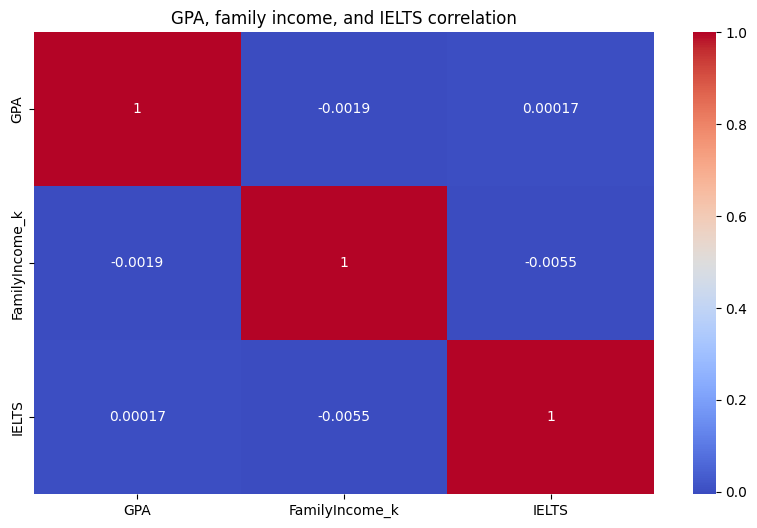

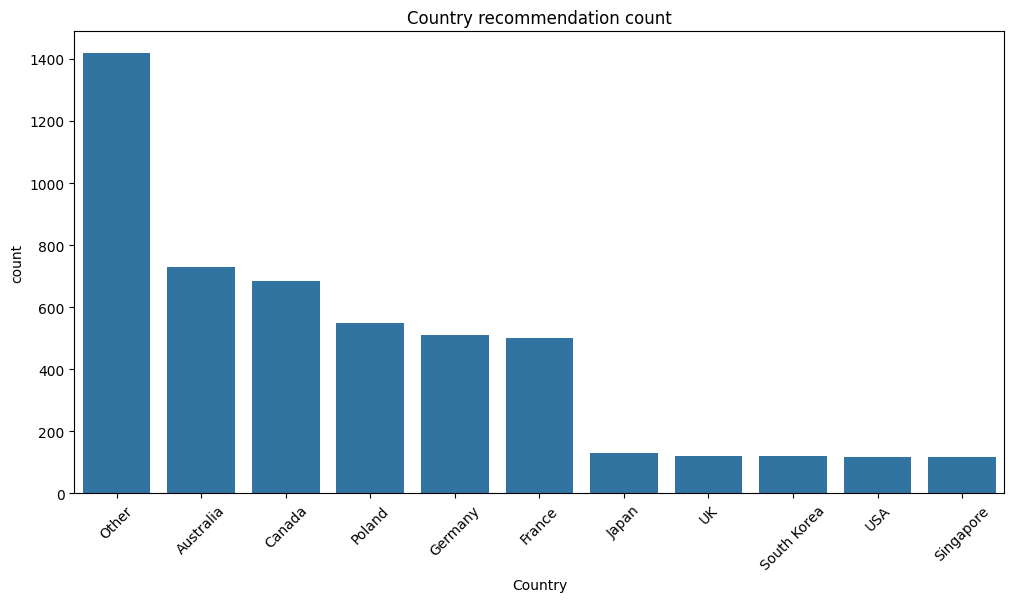

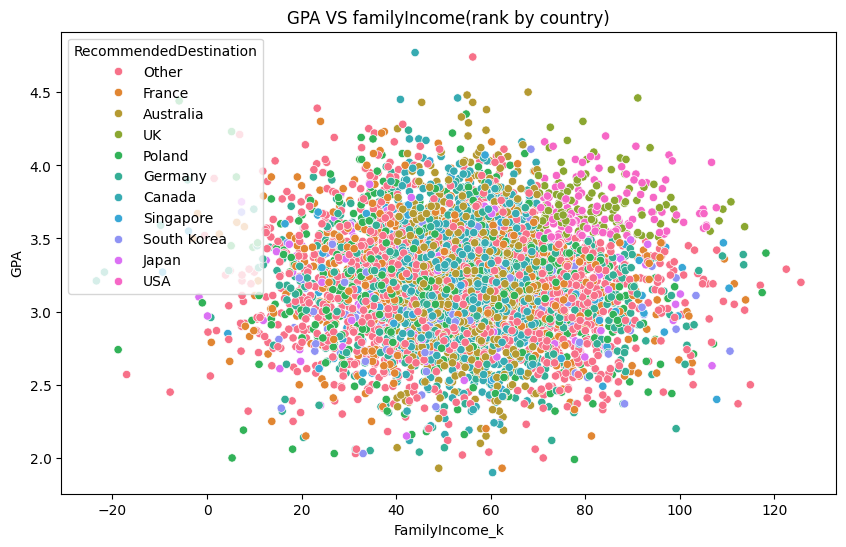

In [9]:

plt.figure(figsize=(10, 6))
sns.heatmap(data[['GPA', 'FamilyIncome_k', 'IELTS']].corr(), annot=True, cmap='coolwarm')
plt.title("GPA, family income, and IELTS correlation")
plt.show()


plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='RecommendedDestination', order=data['RecommendedDestination'].value_counts().index)
plt.title("Country recommendation count")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='FamilyIncome_k', y='GPA', hue='RecommendedDestination')
plt.title("GPA VS familyIncome(rank by country)")
plt.show()


In [10]:

features = ['GPA', 'FamilyIncome_k', 'IELTS']
X = data[features]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


kmeans = KMeans(n_clusters=4, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)


c:\Users\grace\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


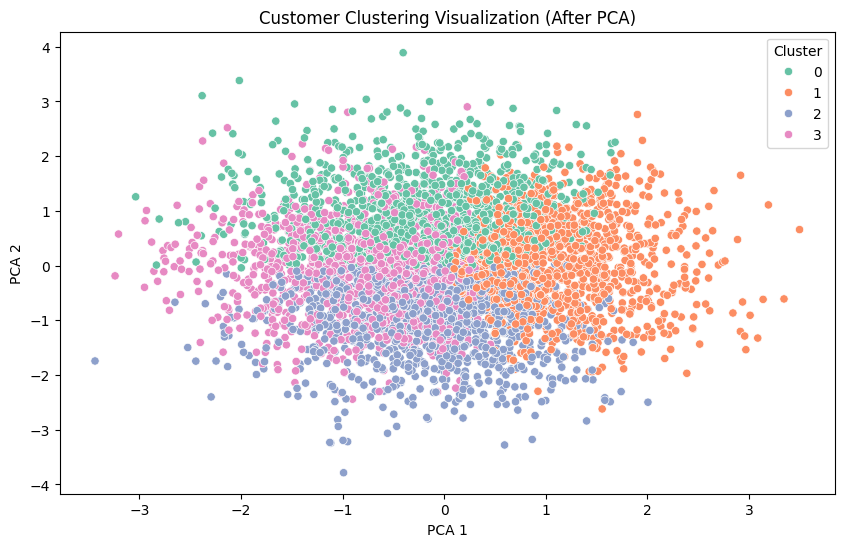

In [11]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['Cluster'], palette='Set2')
plt.title("Customer Clustering Visualization (After PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [12]:

cluster_profiles = data.groupby('Cluster')[['GPA', 'FamilyIncome_k', 'IELTS']].mean().round(2)
print(cluster_profiles)


          GPA  FamilyIncome_k  IELTS
Cluster                             
0        3.53           42.75   5.93
1        3.15           76.61   6.06
2        2.79           42.62   6.50
3        3.34           56.48   7.67


<Axes: xlabel='SegmentLabel', ylabel='count'>

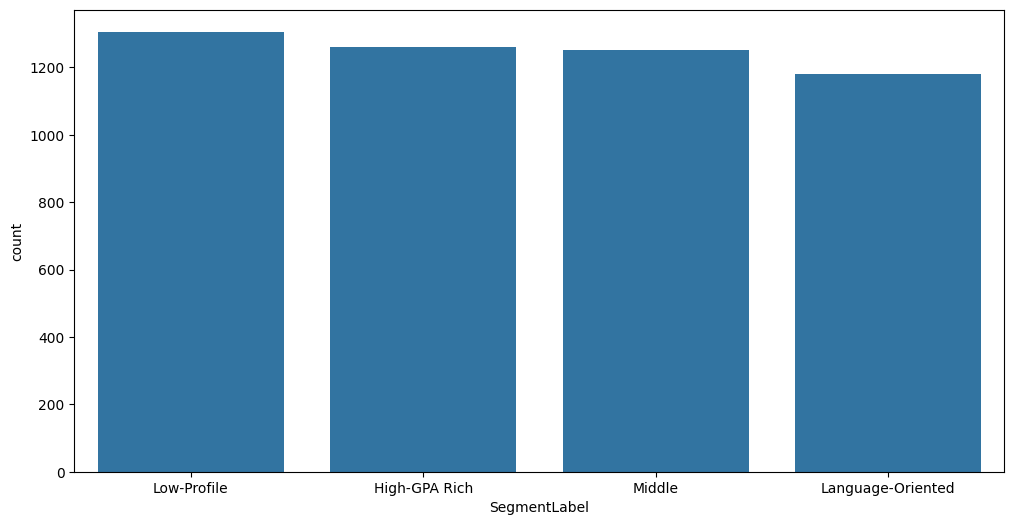

In [13]:
cluster_labels = {
    0: 'High-GPA Rich',
    1: 'Low-Profile',
    2: 'Middle',
    3: 'Language-Oriented'
}

data['SegmentLabel'] = data['Cluster'].map(cluster_labels)
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='SegmentLabel', order=data['SegmentLabel'].value_counts().index)

In [14]:
pd.crosstab(data['SegmentLabel'], data['RecommendedDestination'], normalize='index').round(2)


RecommendedDestination,Australia,Canada,France,Germany,Japan,Other,Poland,Singapore,South Korea,UK,USA
SegmentLabel,,,,,,,,,,,
High-GPA Rich,0.07,0.06,0.14,0.13,0.03,0.34,0.15,0.03,0.02,0.01,0.01
Language-Oriented,0.34,0.32,0.05,0.04,0.01,0.11,0.05,0.01,0.01,0.03,0.04
Low-Profile,0.04,0.03,0.11,0.14,0.04,0.35,0.13,0.03,0.03,0.06,0.05
Middle,0.16,0.14,0.10,0.10,0.02,0.32,0.10,0.02,0.04,0.00,0.00


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

data_encoded = pd.get_dummies(data[['GPA', 'FamilyIncome_k', 'IELTS', 'ProgramInterest', 'ScholarshipPreference', 'CostSensitivity']])

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(data['RecommendedDestination'])

X_train, X_test, y_train, y_test = train_test_split(data_encoded, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

   Australia       0.49      0.54      0.52       134
      Canada       0.54      0.50      0.52       151
      France       0.33      0.31      0.32       102
     Germany       0.38      0.46      0.42        95
       Japan       0.25      0.21      0.23        29
       Other       0.99      1.00      0.99       273
      Poland       0.40      0.34      0.37       125
   Singapore       0.26      0.30      0.28        23
 South Korea       0.38      0.39      0.38        23
          UK       0.45      0.43      0.44        23
         USA       0.47      0.36      0.41        22

    accuracy                           0.58      1000
   macro avg       0.45      0.44      0.44      1000
weighted avg       0.58      0.58      0.58      1000

